In [ ]:
pip install split_folders

In [ ]:
import os, zipfile
import splitfolders
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout, Activation, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# Data Handle
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Import dependencies
from google.colab import files ## Upload file(s) from local
import shutil ## Copy file(s)

import random ## Get random image(s)
import tempfile ## Generate temporary files and directories


# Google Drive Authentication

Link Dataset
https://drive.google.com/file/d/1k5Vfi2ThZa5BevxJ37eSHUKwVFxfRrOH/view?usp=sharing


In [ ]:
!pip install -U -q PyDrive

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1k5Vfi2ThZa5BevxJ37eSHUKwVFxfRrOH/view?usp=sharing'

In [ ]:
id = link.split('d/')[1].split('/view?')[0]
print (id)

1k5Vfi2ThZa5BevxJ37eSHUKwVFxfRrOH


In [ ]:
drive_file = drive.CreateFile({'id':id})
drive_file.GetContentFile('dataset-update.zip')

# Data Gathering

In [ ]:
local_zip = 'dataset-update.zip'
reference_zip = zipfile.ZipFile(local_zip,"r")
reference_zip.extractall("data_update")
reference_zip.close()

In [ ]:
splitfolders.ratio('data_update/dataset-update', output='data_update', seed=1337, ratio=(.8, .2))


Copying files: 6885 files [00:54, 126.53 files/s]


In [ ]:
data_directory = 'data_update'
data_train = os.path.join(data_directory,'train')
data_validation = os.path.join(data_directory,'val')

os.listdir('data_update/train')
os.listdir('data_update/val')

['Type1', 'Type3', 'Type4', 'Type2']

In [ ]:
#cek panjang data training
print(len(os.listdir("data_update/train/Type1")))
print(len(os.listdir("data_update/train/Type2")))
print(len(os.listdir("data_update/train/Type3")))
print(len(os.listdir("data_update/train/Type4")))

1468
1378
1176
1485


In [ ]:
#cek panjang data validation
print(len(os.listdir("data_update/val/Type1")))
print(len(os.listdir("data_update/val/Type2")))
print(len(os.listdir("data_update/val/Type3")))
print(len(os.listdir("data_update/val/Type4")))

367
345
294
372


In [ ]:
directory_type1_train = os.path.join(data_train,"Type1")
directory_type2_train = os.path.join(data_train,"Type2")
directory_type3_train = os.path.join(data_train,"Type3")
directory_type4_train = os.path.join(data_train,"Type4")

directory_type1_validation = os.path.join(data_validation,"Type1")
directory_type2_validation = os.path.join(data_validation,"Type2")
directory_type3_validation = os.path.join(data_validation,"Type3")
directory_type4_validation = os.path.join(data_validation,"Type4")

gambar_type1 = os.listdir(directory_type1_train)
gambar_type2 = os.listdir(directory_type2_train)
gambar_type3 = os.listdir(directory_type3_train)
gambar_type4 = os.listdir(directory_type4_train)

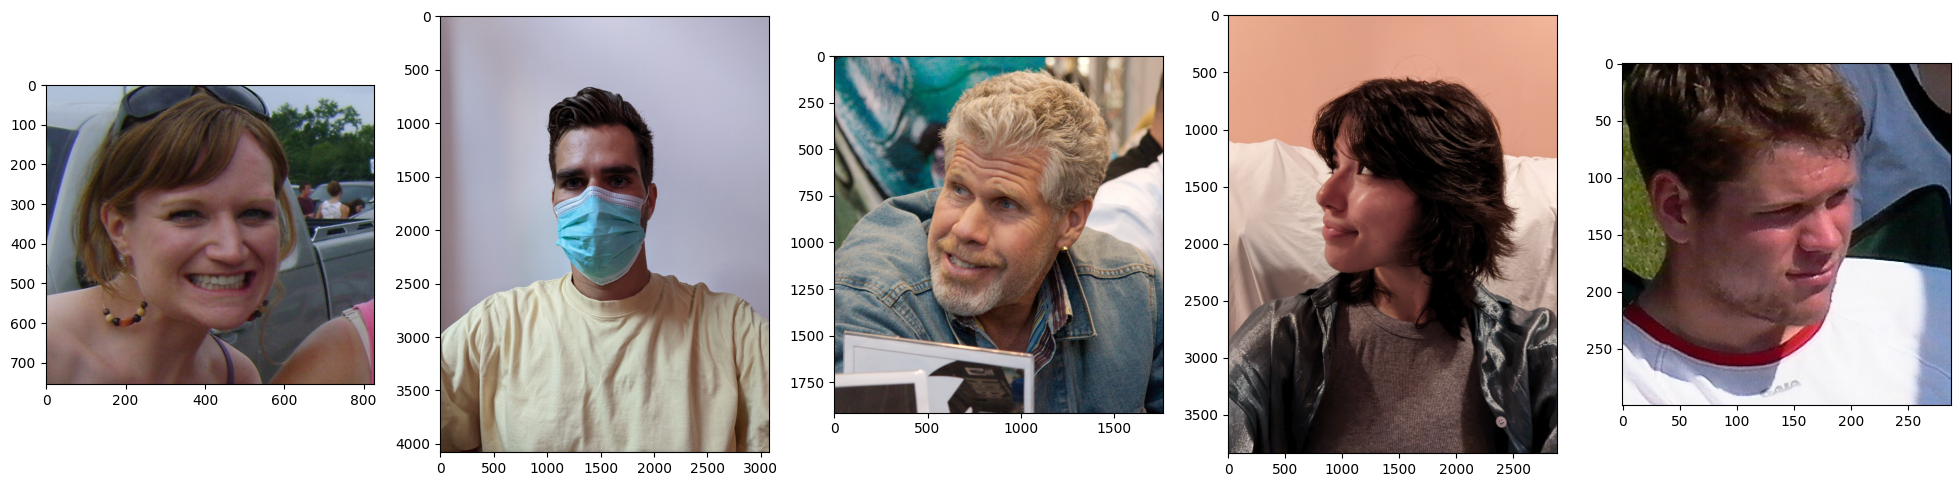

In [ ]:
#import matplotlib

plt.figure(figsize=(50,25))
for i, sumber_gambar in enumerate(gambar_type1[:5]):
  spec = plt.subplot(1,10,i+1)
  gamb = mimg.imread(os.path.join(directory_type1_train, sumber_gambar))
  plt.imshow(gamb)
plt.show()

In [ ]:
#Augmentasi gambar
import scipy

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   validation_split = 0.9999,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(data_train,
                                                    color_mode = "rgb",
                                                    batch_size = 256,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(
    data_validation,
    target_size = (150,150),
    batch_size = 128,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True
)

Found 5486 images belonging to 4 classes.
Found 1376 images belonging to 4 classes.


# Model Architecture

In [ ]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False
)
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
preds = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[0][0]']        

In [ ]:
for layers in model.layers[:-5]:
  layers.trainable = False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[0][0]']        

In [ ]:
# Callbacks schedule
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check
    if logs.get('accuracy') > .90 and logs.get('val_accuracy') > .85:

      # Stop if threshold is met
      print("\nThe thresholds are met so stop training!")
      self.model.stop_training = True

    # Get learning rate callbacks
    #lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Instantiate class
callbacks = myCallback()

# Create simple early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)


# Model checkpoint
model_checkp = tf.keras.callbacks.ModelCheckpoint('model_v1d2_checkp.h5', monitor='val_accuracy',
                                                  mode='max', verbose=1, save_best_only=True)

In [ ]:
optimizer = Adam(learning_rate=.001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 21,
    epochs = 50,
    validation_steps = 10,
    verbose = 1,
    callbacks=[callbacks, model_checkp])

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.5035 - accuracy: 0.5593 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.58516, saving model to model_v1d2_checkp.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 313s 15s/step - loss: 1.5035 - accuracy: 0.5593 - val_loss: 1.2525 - val_accuracy: 0.5852
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.0608 - accuracy: 0.6382 
Epoch 2: val_accuracy improved from 0.58516 to 0.69063, saving model to model_v1d2_checkp.h5
21/21 [==============================] - 300s 14s/step - loss: 1.0608 - accuracy: 0.6382 - val_loss: 0.8609 - val_accuracy: 0.6906
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.9094 - accuracy: 0.6723 
Epoch 3: val_accuracy improved from 0.69063 to 0.71094, saving model to model_v1d2_checkp.h5
21/21 [==============================] - 331s 16s/step - loss: 0.9094 - accuracy: 0.6723 - val_loss: 0.7768 - val_accuracy: 0.7109
Epoch 4/50
21/21 [==============================] - ETA: 0s - loss: 0.8381 - accuracy: 0.6860 
Epoch 4: val_accuracy improved from 0.71094 to 0.71641, saving model to model_v1d2_checkp.h5
21/21 [==============================] - 29

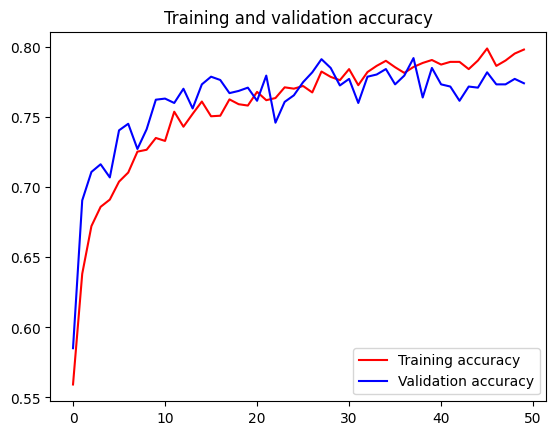

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

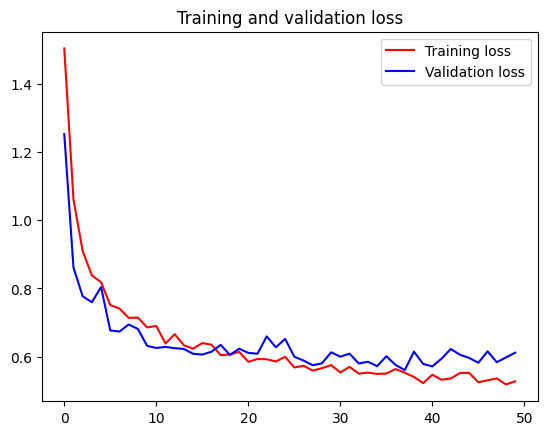

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

# **Save & Export Model**

In [ ]:
# Save the model
## Define temporary directory for save the model
MODEL_DIR = tempfile.gettempdir()
version = 1
diff = 2
version_path = os.path.join(MODEL_DIR, str(version))
export_path = os.path.join(version_path, str(diff))

## Ensure the temporary file
if os.path.isdir(export_path):
    print('\nPrepare the path, cleaning up!\n')
    !rm -r {export_path}

## Save the model
### tf format
model.save(export_path, save_format="tf")
print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}

### h5 keras format
saved_h5_format = './skintone.h5'
model.save(saved_h5_format)


Prepare the path, cleaning up!


export_path = /tmp/1/2
total 2872
drwxr-xr-x 2 root root    4096 Dec  1 07:21 assets
-rw-r--r-- 1 root root      56 Dec  1 07:21 fingerprint.pb
-rw-r--r-- 1 root root  368259 Dec  1 07:21 keras_metadata.pb
-rw-r--r-- 1 root root 2558417 Dec  1 07:21 saved_model.pb
drwxr-xr-x 2 root root    4096 Dec  1 07:21 variables


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Convert to .json format
## Install required library
!pip install tensorflowjs

## Path to .json directory
export_json_path = os.path.join(export_path, 'json_format')

## Ensure the temporary file
if os.path.isdir(export_json_path):
    print('\nPrepare the path, cleaning up!\n')
    !rm -r {export_json_path}

## Convert command
!tensorflowjs_converter --input_format=keras {saved_h5_format} {export_json_path}

##
!zip -r './jsonmodelskin.zip' {export_json_path}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalle

2023-12-01 07:24:14.339071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 07:24:14.339202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 07:24:14.344396: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 07:24:16.027997: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  adding: tmp/1/2/json_format/ (stored 0%)
  adding: tmp/1/2/json_format/group1-shard2of4.bin (deflated 7%)
  adding: tmp/1/2/json_format/model.json (deflated 96%)
  adding: tmp/1/2/json_format/group1-shard1of4.bin (deflated 7%)
  adding: tm

In [ ]:
# Convert to .tflite format
## Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

## Set the optimization strategy for 'size' in the converter
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

## Use the tool to finally convert the model
tflite_model = converter.convert()

## Write TFLite model and its classes
tflite_model_file = 'skintone.tflite'

with open(tflite_model_file, "wb") as tf:
    tf.write(tflite_model)